<a href="https://colab.research.google.com/github/VinayakG2002/NLPlay-with-Transformers/blob/main/BERT_in_Base_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

     |████████████████████████████████| 2.5MB 29.0MB/s 
     |████████████████████████████████| 901kB 45.9MB/s 
     |████████████████████████████████| 3.3MB 36.0MB/s 


In [2]:
pip install datasets

     |████████████████████████████████| 266kB 23.7MB/s 
     |████████████████████████████████| 245kB 42.9MB/s 
     |████████████████████████████████| 122kB 50.4MB/s 


In [3]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import random

In [4]:

url='https://raw.githubusercontent.com/VinayakG2002/NLPlay-with-Transformers/main/IMDB%20Dataset.csv?token=ATKA2LIXPHWLGQT64HBC2KLA6XEPW'
df = pd.read_csv(url)

In [5]:
def remove_tags(text):
    final = ""
    stt = True
    for char in text:
        if char == '<':
            stt = False
        if(stt):
            final = final + char
        if char == '>':
            stt = True
            final = final + ' '
    return final

df['text'] = df['review'].apply(remove_tags)

In [6]:
df = df.drop('review',axis = 1)

In [7]:
df['label'] = [ 1*(sent=='positive') for sent in df['sentiment']]

df = df.drop('sentiment', axis = 1)

In [8]:

from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [9]:
model_name = 'bert-base-uncased'

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
small_train_dataset = dataset.shuffle(seed=42).select(range(2000))
small_eval_dataset = dataset.shuffle(seed=42).select(range(2000,4000))

In [12]:
train_range = [i for i in range(0,30000) if 6>=i%10 and i%10>=0]
eval_range = [i for i in range(0,30000) if 9>=i%10 and i%10>=7]

train_dataset = dataset.select(train_range).shuffle(seed=42)
eval_dataset = dataset.select(eval_range) .shuffle(seed=42)

In [13]:

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=10)
eval_dataloader = DataLoader(eval_dataset, batch_size=10)

In [14]:
from transformers import AutoModel

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [17]:
class Classifier(nn.Module):
  def __init__(self,hidden_dim,output_size,model_name,enc_dim):
    super(Classifier,self).__init__()

    self.model = AutoModel.from_pretrained(model_name, num_labels=2)
  
    self.LF1 = nn.Linear(enc_dim,hidden_dim)
    self.NLF1 = nn.ReLU()

    self.LF2 = nn.Linear(hidden_dim,hidden_dim)
    self.NLF2 = nn.ReLU()

    self.LF3 = nn.Linear(hidden_dim,output_size)

  def ready_train(self):
    (self.model).train()
  
  def ready_eval(self):
    self.model.eval()

  def forward(self,x):
    out = self.model(**x)[1]

    out = self.LF1(out)
    out = self.NLF1(out)

    out = self.LF2(out)
    out = self.NLF2(out)

    out = self.LF3(out)

    return F.softmax(out,dim=1)

In [18]:
from tqdm.auto import tqdm

def train_classifier(num_epochs,train_dataloader,optimizer,classifier, loss_function = nn.CrossEntropyLoss()):
  losses = []
  num_training_steps = num_epochs*len(train_dataloader)
  progress_bar = tqdm(range(num_training_steps))
  classifier.ready_train()
  i = 0
  avg_loss = 0.
  for epoch in range(num_epochs):
    for batch in train_dataloader:
      # forward prop
      inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
      inp = inp.to(device)
      out = classifier(inp)
      pred = batch['label']
      pred = pred.to(device)
      loss = loss_function(out, pred)

      # backward prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
      progress_bar.update(1)
      if i%100 == 0  and i//100>=1:
        print(avg_loss/100)
        avg_loss = 0
      i+=1
      avg_loss = avg_loss + float(loss.item())
  return losses

In [19]:
def plot_loss(losses):
  x = [i for i in range(0,len(losses))]
  plt.plot(x,losses)
  plt.title('Loss fnction')
  plt.ylabel('Loss')
  plt.xlabel('batch index')

def smooth_loss(losses,f):
  y = [0]*len(losses)
  for i in range(0,f):
    y[i] = (sum(losses[:i+1+f]))/(i+1+f)
  for i in range(f,len(losses)-f-1):
    y[i] = (sum(losses[i-f:i+f+1]))/(2*f+1)
  for i in range(len(losses)-f-1,len(losses)):
    y[i] = (sum(losses[i-f:]))/(len(losses)-i+f)
  plot_loss(y)

In [20]:
output_size = 2
hidden_dim = 500
enc_dim = 768

classifier_bert = Classifier(hidden_dim,output_size,model_name,enc_dim)
classifier_bert.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [21]:
num_epochs = 3
lr = 1e-3
optimizer = optim.SGD(classifier_bert.parameters(), lr)

losses = train_classifier(num_epochs,train_dataloader,optimizer,classifier_bert)

0.69339175760746
0.6931443917751312
0.6931119436025619
0.692727860212326
0.6919604504108429
0.6916378402709961
0.6916966032981873
0.6912300318479538
0.6910662525892257
0.690483210682869
0.689664676785469
0.6879493355751037
0.6865372216701507
0.686620545387268
0.6812862139940262
0.6771209055185318
0.6625559359788895
0.6437430649995803
0.6177062606811523
0.5825844323635101
0.5515041822195053
0.5206686463952065
0.5028410232067109
0.4941729786992073
0.4645430490374565
0.4723439678549767
0.45587361305952073
0.46120979368686676
0.4543368428945541
0.4451982155442238
0.4541022199392319
0.4419006496667862
0.4450811263918877
0.43700853019952773
0.4339952126145363
0.4421744155883789
0.44060971319675446
0.4206794172525406
0.41324252665042877
0.44531920552253723
0.4245507284998894
0.4251405790448189
0.42254236578941345
0.41589704155921936
0.4136617770791054
0.42516320616006853
0.4271519166231155
0.41620591819286346
0.4183874568343163
0.4142388904094696
0.43067101389169693
0.40290763944387437
0.3984

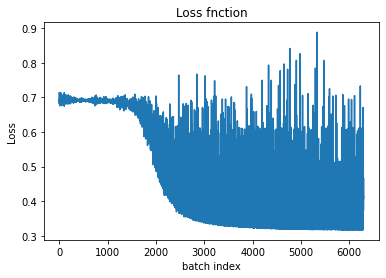

In [22]:
plot_loss(losses)

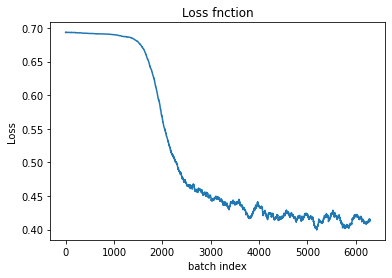

In [23]:

smooth_loss(losses,100)

In [24]:
classifier_bert.ready_eval()
def acc(dataloader,classifier):
  corr = 0
  tot = len(dataloader)*10
  for batch in dataloader:
  # forward prop
    inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
    inp = inp.to(device)
    out = list(torch.argmax(classifier(inp),dim=1))
    exp = list(batch['label'])
    
    for i,x in enumerate(out):
      if x == exp[i]:
        corr = corr+1
    
  return 100*(corr/tot)

In [25]:
acc(train_dataloader,classifier_bert)

92.07619047619048

In [26]:
acc(eval_dataloader,classifier_bert)

91.63333333333334